In [1]:
%load_ext chime
import chime
chime.theme("material")

from joblib import Parallel

import os
import rasterio as rio
from rasterio.enums import ColorInterp
import numpy as np

from datetime import datetime
from skimage.segmentation import felzenszwalb, watershed, quickshift, slic

from skimage import measure
from skimage.measure import label

import geopandas as gpd

import gdal
import logging as logger

from joblib import Parallel, delayed
from skimage.exposure import adjust_sigmoid

import sys

from glob import glob
import geopandas as gpd
import pandas as pd

from skimage.filters import hessian
from skimage.filters.rank import median, mean, mean_bilateral, equalize
from skimage.morphology import disk, ball, square, erosion, dilation, diamond, opening, closing
from skimage.exposure import adjust_log

from utils import *

In [2]:
files = glob("M:/PAG2019/EPCExtent_30cm/Orthos_Segmentedv3/*.tif")
files_dict = {os.path.basename(file):file for file in files}
#W784789_W309850_TrainingStackV3

In [3]:
#https://docs.scipy.org/doc/scipy/reference/ndimage.html
#https://stackoverflow.com/questions/13728392/moving-average-or-running-mean/43200476#43200476
from scipy.ndimage import median_filter, gaussian_filter, generic_filter


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


Reading in boxesdf...
Reading in targetboxes


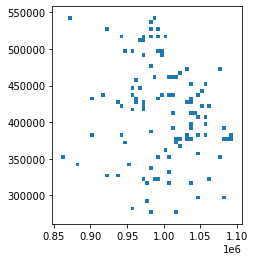

In [4]:
v3TrainingStack_dir = "../EPCExtent_30cm/Orthos_Segmentedv3"
histoEqual_loc = "../EPCExtent_30cm/Orthos_LocalHistogramEqualized"

landcoverExtent_loc = r"../OtherData/LandcoverExtent.gpkg"
targetboxes_loc = "../OtherData/targetBoxes_20201208.gpkg"
hag_tindex_loc = "../EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_tindex.gpkg"
boxesdf_loc = "../EPCExtent_30cm/Ortho_5kSubIndex.gpkg"
orthoseg_loc = "../EPCExtent_30cm/Orthos_Segmented"
ortho15cmvrt_loc = os.path.abspath(r"D:/20191212_AZ_PIMA/2019_UrbanExtent_15cm/UGT_15cmOrtho_2019.vrt")
ortho30cmvrt_loc = os.path.abspath("../EPCExtent_30cm/Orthos/EPC_30cmOrtho_2019.vrt")
hagvrt_loc = os.path.abspath("../EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt")
tileindex_loc = "../EPCExtent_30cm/Orthos/2019_LULC_EPCExtent_30cm_index.shp"

orthos = [os.path.abspath(f) for f in glob("../EPCExtent_30cm/Orthos/*.tif")]

if sys.platform == "linux":
    ortho15cmvrt_loc = ortho15cmvrt_loc.replace("D:", "/media/ben/NWG_Data")

tileindex = gpd.read_file(tileindex_loc)
landcoverExtent = gpd.read_file(landcoverExtent_loc)
hag_tindex = gpd.read_file(hag_tindex_loc)

tifsfootprint = tileindex.geometry.unary_union

if not os.path.exists(boxesdf_loc):
    print("Creating boxesdf...")
    boxesdf = gpd.GeoDataFrame(geometry=boxes,crs="epsg:2868")
    boxesdf["path"] = boxesdf.geometry.apply(lambda g: f"W{int(g.bounds[0])}")
    boxesdf["row"] = boxesdf.geometry.apply(lambda g: f"W{int(g.bounds[3])}")
    boxesdf["filepath"] = boxesdf.apply(lambda r: os.path.join(orthoseg_loc, f"{r.path}_{r.row}_Segmented.tif"), axis=1)
    boxesdf.to_file(boxesdf_loc, driver="GPKG")
else:
    print("Reading in boxesdf...")
    boxesdf = gpd.read_file(boxesdf_loc)


if not os.path.exists(targetboxes_loc):
    print("Creating targetboxes")
    target_place = gpd.read_file(r"/home/ben/Downloads/cb_2018_04_place_500k/cb_2018_04_place_500k.shp").to_crs(boxesdf.crs)
    target_place = target_place[target_place.NAME.isin(["Tucson", "Oro Valley", "Casas Adobes", "Drexel Heights", "Vail", "Green Valley", "Sahuarita"])]
    placetargetboxes = boxesdf[(boxesdf.intersects(target_place.unary_union)) & (boxesdf.within(landcoverExtent.unary_union))].sample(n=75)
    nonplacetargetboxes = boxesdf[~boxesdf.intersects(target_place.unary_union) & (boxesdf.within(landcoverExtent.unary_union))].sample(n=50)
    targetboxes = pd.concat([placetargetboxes, nonplacetargetboxes])
    targetboxes.to_file(targetboxes_loc, driver="GPKG")
else:
    print("Reading in targetboxes")
    targetboxes = gpd.read_file(targetboxes_loc)
    
targetboxes = targetboxes[targetboxes.within(hag_tindex.unary_union)]
%chime
targetboxes.plot()

with rio.open(hagvrt_loc) as src:
    win = from_bounds(*boxrow.geometry.bounds, transform=src.transform)
    hag_array = src.read(window=win, out_shape=(5181,5181))
    #Cleanup HAG array. 2019 elevation data showed +- error of about 1.5 feet
    hag_array[hag_array<1.5] = 0

hag_median = np.array([median(hag_array[0].astype(np.uint8), selem=square(5))])
#had_median_segs = felzenszwalb(np.moveaxis(hag_median, 0, -1), scale=50, sigma=0.5, min_size=100, multichannel=True)
#hag_median_stack = getMeanOfSegments(hag_median.astype(np.uint8), had_median_segs)
had_segs = felzenszwalb(np.moveaxis(hag_array, 0, -1), scale=25, sigma=0.5, min_size=75, multichannel=True)
hag_array_stack = getMeanOfSegments(hag_array.astype(np.uint8), had_segs)
%chime

i = 200
from matplotlib import pyplot
fig, (ax1, ax2, ax3) = pyplot.subplots(1,3, figsize=(35,15))
show(hag_array[:,i:i+700, i:i+700], ax=ax1, cmap='inferno', title="HAG")
show(hag_median[:,i:i+700, i:i+700], ax=ax2, cmap='inferno', title="HAG MEDIAN")
show(hag_array_stack[:,i:i+700, i:i+700], ax=ax3, cmap='inferno', title="HAG SEG")
#show(hag_median_stack[:,i:i+700, i:i+700], ax=ax3, cmap='inferno', title="HAG MEDIAN SEG")
pyplot.show()

In [6]:
%%time
tday = datetime.today().strftime('%Y%m%d')

for i, boxrow in boxesdf.iterrows():
    if boxrow.path == "W994789" and boxrow.row == "W449850":
        print("found")
        testOut = os.path.join("/home/ben/Downloads", "temp" + os.path.basename(boxrow.filepath))
        #out, tkwargs = getOrthoWindow(ortho30cmvrt_loc, boxrow.geometry)
        #getRegionProperties(out, "../temp", overwrite=False)
        %chime
        break

found
Wall time: 175 ms


In [16]:
f = "../EPCExtent_30cm/Orthos_Segmentedv3/W1004789_W279850_TrainingStackV3.tif"
with rio.open(f) as src:
    kwargs = src.profile
    reso = src.res[0]
    x_origin, y_origin = src.bounds.left, src.bounds.top

    #x_origin, y_origin = datads[2], datads[5]
    halfpix_offset = reso/2
    xs = np.array([[x_origin + (pix*reso) + halfpix_offset] for pix in range(src.width)])
    ys = np.array([[y_origin - (pix*reso) - halfpix_offset] for pix in range(src.height)])
    xs = np.moveaxis(xs, 0, -1)
    print("created x/y's")
    x_values = np.repeat(xs, repeats=src.height, axis=0)
    y_values = np.repeat(ys, repeats=src.width, axis=1)
kwargs.update(count=2, dtype=np.float32)
with rio.open("C:/Users/BenJames/Downloads/XYs.tif", "w", **kwargs) as dst:
    dst.write(x_values.astype(np.float32), 1)
    dst.write(y_values.astype(np.float32), 2)

created x/y's


In [6]:
%%time

t = boxesdf[(boxesdf.path == "W954789") & (boxesdf.row == "W379850")]
for i, boxrow in t.iterrows():
    tfile = segmentWindowV3(boxrow, v3TrainingStack_dir, ortho30cmvrt_loc, hagvrt_loc, returnArray=False, overwrite=True)

%chime

<timed exec>:3: RuntimeWarning: Got image with third dimension of 5. This image will be interpreted as a multichannel 2d image, which may not be intended.


Wrote training stack out to W954789_W379850_TrainingStackV3.tif
Wall time: 7min 25s


NameError: name 'outDir' is not defined

In [ ]:
%%time

os.makedirs(v3TrainingStack_dir, exist_ok=True)
t = segmentWindowV3(boxrow, v3TrainingStack_dir, ortho30cmvrt_loc, hagvrt_loc, returnArray=False, overwrite=True)
%chime

In [18]:
%%time

def iterateDF(df, outDir):
    print(f"Starting batch compute for {len(df)} windows")
    outfiles = []

    outfiles += Parallel(n_jobs=6, verbose=5, backend="loky")(delayed(segmentWindowV3)(boxrow,
                                                                                       outDir,
                                                                                       ortho30cmvrt_loc,
                                                                                       hagvrt_loc,
                                                                                       returnArray=False,
                                                                                       writeOutStack=True,
                                                                                       overwrite=False) for i, boxrow in df.iterrows())
print("FINISHED")
    return outfiles
    %chime


v3TrainingStack_dir = "../EPCExtent_30cm/Orthos_Segmentedv3"

trainingBoxes = gpd.read_file("TrainingBoxes.gpkg")
trainingBoxes = trainingBoxes.dissolve(by="PR", as_index=False)
trainingBoxes["filepath"] = trainingBoxes.apply(lambda r: findFile(r.path, r.row, v3TrainingStack_dir),axis=1)
trainingBoxes = trainingBoxes[pd.isnull(trainingBoxes.filepath)]
print(trainingBoxes.shape)


iterateDF(trainingBoxes, v3TrainingStack_dir)
print("FINISHED targetboxes", datetime.now())


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


(979, 7)
Starting batch compute for 979 windows


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 78.2min
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\joblib\externals\loky\process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 192.3min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 346.4min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 562.5min
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed: 833.9min
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed: 1159.0min


FINISHED targetboxes 2021-05-19 16:11:50.594202
Wall time: 21h 58min 17s


[Parallel(n_jobs=6)]: Done 979 out of 979 | elapsed: 1318.2min finished


In [19]:
%chime

In [ ]:
outfiles = []
for i, boxrow in trainingBoxes.iterrows():
    outfile = segmentWindowV3(boxrow, v3TrainingStack_dir, ortho30cmvrt_loc, hagvrt_loc, returnArray=False, writeOutStack=True, overwrite=False)
    outfiles.append(outfile)

In [4]:
trainingBoxes = gpd.read_file("../Scripts/TrainingBoxes.gpkg")

for i, boxrow in trainingBoxes.iterrows():
    if boxrow.path == "W989789" and boxrow.row == "W439850":
        ortho_array, kwargs = getOrthoWindow(ortho30cmvrt_loc, boxrow.geometry)
        print(boxrow)
        break

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


path                                                      W989789
row                                                       W439850
PR                                                W989789 W439850
OrthoSegFile    ../EPCExtent_30cm/Orthos_Segmentedv2\W989789_W...
PropsSegFile    ../EPCExtent_30cm/Orthos_Segmentedv2_propertie...
geometry        POLYGON ((994839.591874 434800.2011459983, 994...
Name: 1097, dtype: object


In [ ]:
from skimage.filters.rank import equalize
from rasterio.plot import show

from skimage.filters.rank import entropy

orthoMB = bilateralMean(ortho_array, 20, s=10)

for i in range(100, 250, 50):
    ortho_copy = orthoMB.copy()
    print(f"Starting disk of size {i}")
    footprint = disk(i)
    for b in range(len(ortho_copy)):
        ortho_copy[b]  = equalize(ortho_copy[b], selem=footprint)
        
    with rio.open(f"../temp/testLocalHist_BM_disk{i}.tif", "w", **kwargs) as dst:
        dst.write(ortho_copy)

In [8]:
%%time

from rasterio.plot import show

from skimage.filters.rank import entropy


entropyDisks = [5, 10, 12, 15]
for ed in entropyDisks:
    ofile = f"../temp//testEntropy_disk{ed}.tif"
    if os.path.exists(ofile):
        continue
    print(ed)
    ortho_entropy = ortho_array.copy()
    start = datetime.now()
    for i in range(4):
        ortho_entropy[i] = entropy(ortho_array[i], disk(ed))
    
    kwargs.update(dtype=np.uint8)
    with rio.open(ofile, "w", **kwargs) as dst:
        dst.write(ortho_entropy)
    print(f"ed size {ed} took {datetime.now()- start}")

%chime

12
ed size 12 took 0:01:48.158996
Wall time: 1min 48s


In [10]:
createLocalHistogramOrtho(boxrow, histoEqual_loc, ortho30cmvrt_loc, overwrite=True)

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\skimage\util\dtype.py:531: UserWarning: Downcasting int32 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Finished with ../EPCExtent_30cm/Orthos_LocalHistogramEqualized\W954789_W379850_TrainingStackV3.tif


'../EPCExtent_30cm/Orthos_LocalHistogramEqualized\\W954789_W379850_TrainingStackV3.tif'

In [13]:
with rio.open('../EPCExtent_30cm/Orthos_LocalHistogramEqualized\\W954789_W379850_TrainingStackV3.tif') as src:
    print(src.width, src.height)

5181 5181


In [9]:
%%time
def iterateDF(df, outDir):
    print(f"Starting batch compute for {len(df)} windows")
    outfiles = []

    outfiles += Parallel(n_jobs=6, verbose=5, backend="loky")(delayed(createLocalHistogramOrtho)(boxrow,
                                                                                                 outDir,
                                                                                                 ortho30cmvrt_loc,
                                                                                                 overwrite=False) for i, boxrow in df.iterrows())
    #print("FINISHED")
    return outfiles
    %chime


v3TrainingStack_dir = "../EPCExtent_30cm/Orthos_Segmentedv3"
histoEqual_loc = "../EPCExtent_30cm/Orthos_LocalHistogramEqualized"
os.makedirs(histoEqual_loc, exist_ok=True)

trainingBoxes = gpd.read_file("../Scripts/TrainingBoxes.gpkg")
trainingBoxes = trainingBoxes.dissolve(by="PR", as_index=False)
trainingBoxes["filepath"] = trainingBoxes.apply(lambda r: findFile(r.path, r.row, v3TrainingStack_dir),axis=1)
trainingBoxes = trainingBoxes[pd.isnull(trainingBoxes.filepath)]

iterateDF(trainingBoxes, outDir=histoEqual_loc)
print("FINISHED targetboxes", datetime.now())
iterateDF(boxesdf, outDir=histoEqual_loc)
print("FINISHED boxesdf", datetime.now())
%chime

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


Wall time: 13 s


In [12]:
%chime

In [27]:
files = glob(histoEqual_loc+"/*.tif")
bands = ["RED", "GREEN", "BLUE", "NIR"]

for i, f in enumerate(files):
    with rio.open(f, "r+") as src:
        if i%50 == 0:
            print(src.descriptions)
        for i, band in enumerate(bands):
            src.set_band_description(i+1, band + "_LHE")

('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')
('RED_LHE', 'GREEN_LHE', 'BLUE_LHE', 'NIR_LHE')


In [32]:
from skimage.filters import gaussian

def diffOfGaus(img, sig1, sig2):
    img_sig1 = gaussian(img, sigma=sig1)
    img_sig2 = gaussian(img, sigma=sig2)
    
    return img_sig1 - img_sig2


lowSig = 50
highSig = 200
ortho_diffGaus = ortho_array.copy()
for i in range(len(ortho_diffGaus)):
    ortho_diffGaus[i] = diffOfGaus(ortho_diffGaus[i], lowSig, highSig)

kwargs.update(dtype=np.float32)
with rio.open(f"../temp/testDiffGaus_S{lowSig}toS{highSig}.tif", "w", **kwargs) as dst:
    dst.write(ortho_stddev)

In [33]:
%chime

In [11]:
from skimage.filters import sobel
from skimage.future import graph

In [ ]:
start = datetime.now()
def merge_boundary(graph, src, dst):
    """Call back called before merging 2 nodes.

    In this case we don't need to do any computation here.
    """
    pass

def weight_boundary(graph, src, dst, n):
    """
    Handle merging of nodes of a region boundary region adjacency graph.

    This function computes the `"weight"` and the count `"count"`
    attributes of the edge between `n` and the node formed after
    merging `src` and `dst`.


    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the "weight" and "count" attributes to be
        assigned for the merged node.

    """
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }


for i in range(len(ortho_array)):
    img = ortho_array[i]
    edges = sobel(img)
    print(datetime.now()-start)
    ortho_array_segs = felzenszwalb(img, scale=25, sigma=0.5, min_size=3)#, multichannel=True)
    print(datetime.now()-start)
    labels = label(ortho_array_segs, connectivity=1).astype(np.float32) + 1
    print(datetime.now()-start)
    
    g = graph.rag_boundary(labels.astype(np.uint32), edges)
    print(datetime.now()-start)
    labels2 = graph.merge_hierarchical(labels, g, thresh=0.08, rag_copy=False,
                                       in_place_merge=True,
                                       merge_func=merge_boundary,
                                       weight_func=weight_boundary)
    print(datetime.now()-start)
    
    break
    
%chime

0:00:00.667100
0:01:06.540969
0:01:06.953804
0:01:24.654081


In [41]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

for theta in (0, 0.25, 0.5, 1):
    theta = round(theta / 4. * np.pi, 4)
    for freq in (0.1, 0.2, 0.3, 0.4):
        kernel = gabor_kernel(freq, theta=theta)
        gabTexture = [power(ortho_array[i], kernel) for i in range(len(ortho_array))]

        kwargs.update(dtype=np.float32)
        with rio.open(f"C:/Users/BenJames/Downloads/tempGabKernal_freq{freq}_theta{theta}.tif", "w", **kwargs) as dst:
            dst.write(np.stack(gabTexture).astype(np.float32))

%chime

In [17]:
def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)
# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

(4, 5079, 5079)

## Possible Best Stack Builder (2021-05-14)

In [15]:
%%time

bmness_stack = getNessStack(bilateralMean(out,10,10))
bmness_stack = rescaleAndStretch(bmness_stack, dtype=np.uint16)
tkwargs.update(count=5, dtype=ness_stack.dtype)
#with rio.open("../temp/testNessStack.tif", "w", **tkwargs) as dst:
#    dst.write(ness_stack)

#cut = 0.3
#gain = 10
#ness_stack_contrast = adjust_sigmoid(rescale_intensity(ness_stack, out_range=np.uint16), cutoff=cut, gain=gain, inv=False)
#tkwargs.update(dtype= ness_stack_contrast.dtype)
#with rio.open(f"../temp/testNessStack_AdjSigC{str(cut).replace('.','')}G{gain}.tif", "w", **tkwargs) as dst:
#    dst.write(ness_stack_contrast)
    
tkwargs.update(dtype=bmness_stack.dtype, count=5)
with rio.open("../temp/testMB10NessStack.tif", "w", **tkwargs) as dst:
    dst.colorinterp = [ColorInterp.red, ColorInterp.green, ColorInterp.blue, ColorInterp.undefined, ColorInterp.undefined]
    dst.write(bmness_stack)
%chime

0 65535
0 65535
0 65535
0 65535
0 65535
Wall time: 1min 2s


In [16]:
%%time
scale=25
sigma=0.5
min_size=15

ness_segs = felzenszwalb(np.moveaxis(bmness_stack,0,-1), scale=scale, sigma=sigma, min_size=min_size, multichannel=True)
ness_labels = label(ness_segs, connectivity=1).astype(np.float32) + 1
out_stack_ness = getPropertyOfSegments(bmness_stack, ness_segs, ness_labels, properties=["mean"])
out_stack_ness = np.stack(out_stack_ness)
out_stack_ortho = getPropertyOfSegments(out, ness_segs, ness_labels, properties=["mean"])
out_stack_ortho = np.stack(out_stack_ortho)

tkwargs.update(count=5, dtype=np.uint16)
with rio.open(f"../temp/testBM10NessSegmented_Sc{scale}Si{sigma}MS{min_size}_Ness.tif", "w", **tkwargs) as dst:
    dst.write(out_stack_ness)
    
tkwargs.update(count=4, dtype=np.uint16)
with rio.open(f"../temp/testBM10NessSegmented_Sc{scale}Si{sigma}MS{min_size}_Ortho.tif", "w", **tkwargs) as dst:
    dst.write(out_stack_ortho)

%chime

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\IPython\core\magics\execution.py:1321: RuntimeWarning: Got image with third dimension of 5. This image will be interpreted as a multichannel 2d image, which may not be intended.
  exec(code, glob, local_ns)


Wall time: 3min 48s


In [31]:
%chime

In [27]:
%%time
scale=50
sigma=0.5
min_size=25

ness_segs = felzenszwalb(np.moveaxis(ness_stack_scale,0,-1), scale=scale, sigma=sigma, min_size=min_size, multichannel=True)
ness_labels = label(ness_segs, connectivity=1).astype(np.float32) + 1
out_stack_ness = getPropertyOfSegments(ness_stack, ness_segs, ness_labels, properties=["mean"])
out_stack_ness = np.stack(out_stack_ness)
out_stack_ortho = getPropertyOfSegments(out, ness_segs, ness_labels, properties=["mean"])
out_stack_ortho = np.stack(out_stack_ortho)

tkwargs.update(count=5, dtype=np.uint16)
with rio.open(f"../temp/testNessScaleSegmented_Sc{scale}Si{sigma}MS{min_size}_Ness.tif", "w", **tkwargs) as dst:
    dst.write(out_stack_ness)
    
tkwargs.update(count=4, dtype=np.uint16)
with rio.open(f"../temp/testNessScaleSegmented_Sc{scale}Si{sigma}MS{min_size}_Ortho.tif", "w", **tkwargs) as dst:
    dst.write(out_stack_ortho)

%chime

Wall time: 3min 19s


In [23]:
out_scale = rescaleAndStretch(out, dtype=np.uint16)

tkwargs.update(count=5)
#with rio.open("../temp/tempNessStackScale.tif", "w", **tkwargs) as dst:
#    dst.write(ness_stack_scale.astype(np.uint16))

nessScale_segs = felzenszwalb(np.moveaxis(ness_stack_scale,0,-1), scale=50, sigma=0.5, min_size=12, multichannel=True)
nessScale_labels = label(nessScale_segs, connectivity=1).astype(np.float32) + 1
out_stack_nessScale = getPropertyOfSegments(ness_stack_scale, nessScale_segs, nessScale_labels, properties=["mean"])
out_stack_nessScale = np.stack(out_stack_nessScale)
out_stack_orthoScale = getPropertyOfSegments(out_scale, nessScale_segs, nessScale_labels, properties=["mean"])
out_stack_orthoScale = np.stack(out_stack_orthoScale)

tkwargs.update(count=5, dtype=np.uint16)
with rio.open("../temp/testNessScaleSegmented_NessScale.tif", "w", **tkwargs) as dst:
    dst.write(out_stack_nessScale)
    
tkwargs.update(count=4, dtype=np.uint16)
with rio.open("../temp/testNessScaleSegmented_OrthoScale.tif", "w", **tkwargs) as dst:
    dst.write(out_stack_orthoScale)
    
%chime

0 65535
0 65535
0 65535
0 65535


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\IPython\core\interactiveshell.py:3441: RuntimeWarning: Got image with third dimension of 5. This image will be interpreted as a multichannel 2d image, which may not be intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [167]:
msavi_mask = msavi_float>-0.1


s= 20
ds = 21
msavi_mb = mean_bilateral(normToUint8(msavi_float), disk(ds), s0=s, s1=s)#, mask=msavi_mask)

tkwargs.update(count=1, dtype=np.float32)
with rio.open(f"../temp/testMSAVI_mb_{ds}_{s}_{s}.tif", "w", **tkwargs) as dst:
    dst.write(msavi_mb.astype(np.float32),1)
%chime

msavi_mb.dtype

dtype('uint8')

In [103]:
kss = 500
ks = (kss,
      kss,
      kss)

kernel_size = np.array(kernel_size)
out_eah = []
for i in range(4):
    out_eah.append(equalize_adapthist(out[i], kernel_size=kss, clip_limit=0.2))
out_eah = np.stack(out_eah, axis=0)
print(out_eah.shape)
#out_eah = np.moveaxis(out_eah,-1,0)
#for i in range(3):
#    out_eah[i] = opening(out_eah[i], square(5))
tkwargs.update(count=4, dtype=np.float32)
with rio.open(f"../temp/testAEH_{kss}.tif", "w", **tkwargs) as dst:
    dst.write(out_eah.astype(np.float32))
%chime

(4, 5181, 5181)


In [ ]:
import math
from datetime import datetime

from skimage.filters.rank import enhance_contrast

targetw, targeth = (5000,5000)
buffer = 50
tday = datetime.now().strftime("%Y%m%d")
segments_dir = os.path.abspath(f"../EPCExtent_30cm/Segments_{tday}")
os.makedirs(segments_dir, exist_ok=True)
boxes = []
with rio.open(ortho30cmvrt_loc) as src:
    kwargs = src.profile
    bnds = src.bounds
    crswidth = src.width * src.res[0]
    crsheight = src.height * src.res[1]

    allwindows = []
    for x in range(0, math.ceil(crswidth/targetw)):
        for y in range(0, math.ceil(crsheight/targeth)):
            xleft = bnds.left + (x*targetw)
            xright = xleft + targetw
            ybottom = bnds.bottom + (y*targeth)
            ytop = ybottom + targeth
            #print(xright-xleft, ytop-ybottom)
            # add buffer
            xmin = max(bnds.left, xleft-buffer)
            xmax = min(bnds.right, xright+buffer)
            ymin = max(bnds.bottom, ybottom-buffer)
            ymax = min(bnds.top, ytop+buffer)
            
            #shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
            subbox = box(xmin, ymin, xmax, ymax)
            
            twin = from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
            if subbox.intersects(tifsfootprint):
                allwindows.append(twin)
                boxes.append(subbox)

    
def getToDo(df, seg_loc):
    filesdone = glob(seg_loc+"/*.tif")
    todo_df = df[~df.filepath.isin(filesdone)]
    return todo_df

In [7]:
boxesdf.head()

,path,row,filepath,geometry
0,W779839,W284850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 279750.201, 784889.592 28..."
1,W779839,W289850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 284750.201, 784889.592 28..."
2,W779839,W294850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 289750.201, 784889.592 29..."
3,W779839,W299850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 294750.201, 784889.592 29..."
4,W779839,W304850,/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segm...,"POLYGON ((784889.592 299750.201, 784889.592 30..."


In [8]:
rural_regions = gpd.read_file(r"../../OtherData/TrainingData/DesertBarrenVegetation_2015.gpkg")
rural_boxes = boxesdf[boxesdf.intersects(rural_regions.unary_union)]
rural_boxes = rural_boxes[rural_boxes.within(hag_tindex.unary_union)]
#rural_boxes.to_file("/home/ben/Downloads/rural_boxes.gpkg", driver="GPKG")
print(rural_boxes.shape)

urbanboxes = gpd.read_file("../../OtherData/UrbanBoxes.gpkg")
print(urbanboxes.shape)

(338, 4)
(137, 4)


In [ ]:
contrastSegLoc

In [62]:
targetboxes.filepath.values[0]

'/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmented/W994789_W494850_Segmented.tif'

In [143]:
%%time

def iterateDF(df, orthosegLoc):
    df["filepath"] = df["filepath"].apply(lambda fp: os.path.join(orthosegLoc, os.path.basename(fp)))
    df_todo = getToDo(df, seg_loc=orthosegLoc).reset_index()
    print(f"Starting batch compute for {len(df_todo)} windows")
    outfiles=[]
    njobs=4
    while len(df_todo)>0 and njobs>=1:
        print(f"{len(df_todo)} remaining. Using {njobs} jobs")
        try:
            #segmentWindow(i, ortho30cmvrt_loc, hagvrt_loc, boxrow.geometry, testOut, overwrite=True)
            outfiles += Parallel(n_jobs=njobs, verbose=5, backend="loky")(delayed(segmentWindow)(i, ortho30cmvrt_loc, hagvrt_loc, boxrow.geometry, boxrow.filepath, overwrite=False) for i, boxrow in df_todo.iterrows())
        except Exception as e:
            print(f"Job batch failed as {e} with job size at {njobs}. Reducing jobs")

        njobs-=1
        df_todo = getToDo(df, seg_loc=orthosegLoc).reset_index()


    print("FINISHED")
    return outfiles
    %chime

contrastSegLoc = "/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2"
os.makedirs(contrastSegLoc, exist_ok=True)


iterateDF(targetboxes, orthosegLoc=contrastSegLoc)
print("FINISHED targetboxes", datetime.now())
iterateDF(urbanboxes, orthosegLoc=contrastSegLoc)
print("FINISHED urbanboxes", datetime.now())
iterateDF(rural_boxes, orthosegLoc=contrastSegLoc)
print("FINISHED ruralboxes", datetime.now())
iterateDF(boxesdf, orthosegLoc=contrastSegLoc)
print("FINISHED boxesdf", datetime.now())

Starting batch compute for 0 windows
FINISHED
FINISHED targetboxes 2021-02-01 14:53:31.081977
Starting batch compute for 0 windows
FINISHED
FINISHED urbanboxes 2021-02-01 14:53:31.087963
Starting batch compute for 0 windows
FINISHED
FINISHED ruralboxes 2021-02-01 14:53:31.093950
Starting batch compute for 2146 windows
2146 remaining. Using 4 jobs


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 33.7min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 193.3min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed: 384.6min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 611.7min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 868.3min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 1178.6min


411 remaining. Using 3 jobs


[Parallel(n_jobs=4)]: Done 2146 out of 2146 | elapsed: 1503.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   15.6s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed:  4.9min


411 remaining. Using 2 jobs


[Parallel(n_jobs=3)]: Done 411 out of 411 | elapsed:  7.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   18.5s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=2)]: Done 411 out of 411 | elapsed:  9.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


411 remaining. Using 1 jobs
FAILED for #0 - /mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2/W784789_W189850_Segmented.tif
Read or write failed. /mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt: Access window out of range in RasterIO().  Requested (0,129739) of size 1x1 on raster of 114499x129739.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


FAILED for #1 - /mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2/W784789_W194850_Segmented.tif
Read or write failed. /mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt: Access window out of range in RasterIO().  Requested (0,129739) of size 1x1 on raster of 114499x129739.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


FAILED for #2 - /mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2/W784789_W199850_Segmented.tif
Read or write failed. /mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt: Access window out of range in RasterIO().  Requested (0,129739) of size 1x1 on raster of 114499x129739.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s


FAILED for #3 - /mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2/W784789_W204850_Segmented.tif
Read or write failed. /mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt: Access window out of range in RasterIO().  Requested (0,129739) of size 1x1 on raster of 114499x129739.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.4s remaining:    0.0s


FAILED for #4 - /mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2/W784789_W209850_Segmented.tif
Read or write failed. /mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt: Access window out of range in RasterIO().  Requested (0,129739) of size 1x1 on raster of 114499x129739.
FAILED for #5 - /mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2/W784789_W214850_Segmented.tif
Read or write failed. /mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt: Access window out of range in RasterIO().  Requested (0,129739) of size 1x1 on raster of 114499x129739.
FAILED for #6 - /mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2/W784789_W219850_Segmented.tif
Read or write failed. /mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt: Access window out of range in RasterIO().  Requested (0,129739) of size 1x1 on raster of 114499x129739.
FAILED for #7 - /mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2/W784789_W224850_Segmente

[Parallel(n_jobs=1)]: Done 411 out of 411 | elapsed: 17.9min finished


In [64]:
tags = ["RED","GREEN","BLUE","NIR","MSAVI","NDVI","HAG"]
contrastSegLoc = "M:/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2"

orthosSegmented = glob(contrastSegLoc + "/*.tif")
for file in orthosSegmented:
    with rio.open(file, "r+") as src:
        src.colorinterp = [ColorInterp.red, ColorInterp.green, ColorInterp.blue, ColorInterp.undefined, ColorInterp.undefined, ColorInterp.undefined, ColorInterp.undefined]
        for i, tag in enumerate(tags):
            src.update_tags(i+1, NAME=tag)


In [16]:
orthofiles = glob("../../EPCExtent_30cm/Orthos/*.tif")
print(orthofiles[0])
with rio.open(orthofiles[0]) as src:
    tags = [src.tags(i+1) for i in range(src.count)]
    print(src.colorinterp)
    #src.colorinterp = (ColorInterp.red, ColorInterp.green, ColorInterp.blue, ColorInterp.undefined)

with rasterio.open('/tmp/rgb.tif', 'r+', **profile) as src:
    src.colorinterp = [ColorInterp.red, ColorInterp.green, ColorInterp.blue, ColorInterp.undefined]
    print(tags)

../../EPCExtent_30cm/Orthos\E0780_N190.tif
(<ColorInterp.red: 3>, <ColorInterp.green: 4>, <ColorInterp.blue: 5>, <ColorInterp.undefined: 0>)
[{}, {}, {}, {}]


In [20]:
%%time
propertiesLocation = "/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmentedv2_properties"
segmentsLocation = "/mnt/Bertha/PAG2019/EPCExtent_30cm/Segments"

if sys.platform != "linux":
    propertiesLocation = propertiesLocation.replace("/mnt/Bertha","M:")
    segmentsLocation = segmentsLocation.replace("/mnt/Bertha","M:")
os.makedirs(propertiesLocation, exist_ok=True)

segmentsFiles = glob(segmentsLocation + "/*.tif")

outfiles=[]
njobs=6
while njobs>=1:
    print(f"Using {njobs} jobs")
    try:
        outfiles += Parallel(n_jobs=njobs, verbose=5, backend="loky")(delayed(getRegionProperties)(file, propertiesLocation, overwrite=False) for file in segmentsFiles)
    except Exception as e:
        print(f"Job batch failed as {e} with job size at {njobs}. Reducing jobs")

    njobs-=1

filesDone = glob(propertiesLocation + "/*.tif")
if len(segmentsFiles) != len(filesDone):
    print("ERROR. Unable to complete all segment files.")
else:
    print("FINISHED. No errors")

%chime


Using 6 jobs


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   11.9s
[Parallel(n_jobs=6)]: Done  72 tasks      | elapsed:   12.2s
[Parallel(n_jobs=6)]: Done 3480 tasks      | elapsed:   15.8s
[Parallel(n_jobs=6)]: Done 4015 out of 4015 | elapsed: 84.3min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Using 5 jobs


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   14.1s
[Parallel(n_jobs=5)]: Done 116 tasks      | elapsed:   14.4s
[Parallel(n_jobs=5)]: Done 3971 tasks      | elapsed:   15.4s
[Parallel(n_jobs=5)]: Done 4015 out of 4015 | elapsed:   15.5s finished


Using 4 jobs


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 152 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 4015 out of 4015 | elapsed:   12.8s finished


Using 3 jobs


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   10.0s
[Parallel(n_jobs=3)]: Done 786 tasks      | elapsed:   10.5s
[Parallel(n_jobs=3)]: Done 4015 out of 4015 | elapsed:   11.4s finished


Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done 3682 tasks      | elapsed:   10.5s
[Parallel(n_jobs=2)]: Done 4015 out of 4015 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Using 1 jobs
File exists skipping W1004789_W269850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W274850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W279850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W284850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W289850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W294850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W299850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W304850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W309850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W314850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W319850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W324850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W329850_Segmented_Segments_regionProps.tif
File exists skipping W1004789_W334850_

[Parallel(n_jobs=1)]: Done 4015 out of 4015 | elapsed:    4.6s finished


# TESTING ONLY

testSeg_loc = "../../EPCExtent_30cm/testLocation"
os.makedirs(testSeg_loc, exist_ok=True)

tester = boxesdf[(boxesdf.path=="W1024789") & (boxesdf.row=="W434850")].copy()
tester.filepath = tester.filepath.apply(lambda f: os.path.join(testSeg_loc, os.path.basename(f)))
display(tester)

print(f"Starting compute for {len(tester)} windows")


for i, boxrow in tester.iterrows():
    outfile = segmentWindow(i,
                            ortho30cmvrt_loc,
                            hagvrt_loc,
                            boxrow.geometry,
                            boxrow.filepath,
                            overwrite=True)
    
print(f"No remaining to compute")
%chime

In [39]:
boxesdf[boxesdf.within(hag_tindex.unary_union)].shape

(2689, 4)

In [40]:
boxesdf.shape

(4426, 4)

In [47]:
a = np.array([1])
(a+1)/2*255

array([255.])

In [34]:
def recreateMSAVI(index, ortho, geom, opath_segmented):
    ofile_segments = os.path.basename(opath_segmented)
    opath_segments = os.path.join(segments_dir, ofile_segments)

    wstart = datetime.now()
    try:
        with rio.open(ortho) as src:
            nbands = src.count
            win = from_bounds(*geom.bounds, transform=src.transform)
            win_transform = src.window_transform(win)
            if src.res[0] > 0.6:
                bandNIR = src.read(4, window=win)
                bandRed = src.read(1, window=win)
            else:
                print("Resampling on read")
                upscale_factor = 0.5
                win_transform = Affine(win_transform.a / upscale_factor, win_transform.b, win_transform.c, win_transform.d, win_transform.e / upscale_factor, win_transform.f)
                bandNIR = src.read(4, window=win, out_shape=(1,
                                      int(win.height * upscale_factor),
                                      int(win.width * upscale_factor)),
                                   resampling=Resampling.nearest)
                bandRed = src.read(1, window=win, out_shape=(1,
                                      int(win.height * upscale_factor),
                                      int(win.width * upscale_factor)),
                                   resampling=Resampling.nearest)


        bandRed = bandRed/255.0
        bandNIR = bandNIR/255.0
        msavi_float = ((2 * bandNIR + 1) - np.sqrt(np.square(2 * bandNIR + 1) - (8 * (bandNIR - bandRed)))) / 2
        ndvi_float = (bandNIR - bandRed) / (bandNIR + bandRed)

        # lowest should be -1 so move to zero. highest (1) goes to 2
        msavi_norm = ((msavi_float+1)/2) * 255 
        ndvi_norm = ((ndvi_float+1)/2) * 255

        msavi_norm = msavi_norm.astype(np.uint8)
        ndvi_norm =  ndvi_norm.astype(np.uint8)
        msavi_segs = segmentVIArray(msavi_norm, seg_type="felzenswalb")
        ndvi_segs = segmentVIArray(ndvi_norm, seg_type="felzenswalb")

        msavi = getMeanOfSegments(np.array([msavi_norm]), msavi_segs)
        ndvi =  getMeanOfSegments(np.array([ndvi_norm]), ndvi_segs)
        with rio.open(os.path.join("../../EPCExtent_30cm/Orthos_Segmented_old", os.path.basename(opath_segmented))) as src:
            kwargs = src.profile
            full_stack = src.read()

        full_stack[4] = msavi[0]
        full_stack[5] = ndvi[0]

        with rio.open(os.path.join("../../EPCExtent_30cm/Orthos_Segmented",os.path.basename(opath_segmented)), "w", **kwargs) as dst:
            dst.write(full_stack)

        wend = datetime.now()
        print(f"Finished for #{index}  -  {os.path.basename(opath_segmented)} in {wend-wstart} - {datetime.now()}")
    except Exception as e:
        print(f"FAILED on \t{opath_segmented}\n{e}")
        return None
    
    return opath_segmented

In [19]:
%chime

In [9]:
if 'win32' in sys.platform:
    downloads = os.path.abspath("C:/Users/BenJames/Downloads")
    boxesdf["filepath"] = boxesdf["filepath"].apply(lambda fp: os.path.abspath(fp.replace("/mnt/Bertha","M:")))
    rural_boxes["filepath"] = rural_boxes["filepath"].apply(lambda fp: os.path.abspath(fp.replace("/mnt/Bertha","M:")))
    targetboxes["filepath"] = targetboxes["filepath"].apply(lambda fp: os.path.abspath(fp.replace("/mnt/Bertha","M:")))
    urbanboxes["filepath"] = urbanboxes["filepath"].apply(lambda fp: os.path.abspath(fp.replace("/mnt/Bertha","M:")))
else:
    downloads = os.path.abspath("/home/ben/Downloads")
    
#boxesdf["filepath"] = boxesdf["filepath"].apply(lambda f: f.replace("Orthos_Segmented", "Orthos_Segmented_old"))
#rural_boxes["filepath"] = rural_boxes["filepath"].apply(lambda f: f.replace("Orthos_Segmented", "Orthos_Segmented_old"))
#targetboxes["filepath"] = targetboxes["filepath"].apply(lambda f: f.replace("Orthos_Segmented", "Orthos_Segmented_old"))
#boxesdf["exists"] = boxesdf["filepath"].apply(lambda f: os.path.exists(f))
#rural_boxes["exists"] = rural_boxes["filepath"].apply(lambda f: os.path.exists(f))
#targetboxes["exists"] = targetboxes["filepath"].apply(lambda f: os.path.exists(f))

#boxesdf = boxesdf[boxesdf.exists == True]
#rural_boxes = rural_boxes[rural_boxes.exists == True]
#targetboxes = targetboxes[targetboxes.exists == True]
targetboxes.shape

(106, 4)

In [ ]:
boxesdf["filepath"] = boxesdf["filepath"].apply(lambda fp: os.path.join("/mnt/Bertha/PAG2019/EPCExtent_30cm/Orthos_Segmented_ContrastAdjust", os.path.basename(fp)))

boxesdf_todo = getToDo(boxesdf, seg_loc=orthoseg_loc).reset_index()
print(f"Starting batch compute for {len(boxesdf_todo)} windows")
outfiles=[]
njobs=4
while len(boxesdf_todo)>0 and njobs>=1:
    #boxesdf_todo = getToDo(targetboxes, seg_loc=orthoseg_loc)
    #for i, boxrows in boxesdf_todo.iterrows():
    print(f"{len(boxesdf_todo)} remaining. Using {njobs} jobs")
    try:
        outfiles += Parallel(n_jobs=njobs, verbose=5, backend="loky")(delayed(recreateMSAVI)(i, ortho30cmvrt_loc, boxrow.geometry, boxrow.filepath) for i, boxrow in boxesdf_todo.iterrows())
    except:
        print(f"Job batch failed with job size at {njobs}. Reducing jobs")

    njobs-=1
    boxesdf_todo = getToDo(boxesdf, seg_loc=orthoseg_loc).reset_index()


print("FINISHED BOXESDF")
%chime

In [48]:
dones = [os.path.basename(f) for f in glob("../../EPCExtent_30cm/Orthos_Segmented_old/*.tif")]
boxesdf["file"] = boxesdf["filepath"].apply(lambda f: os.path.basename(f))
boxesdf = boxesdf[boxesdf["file"].isin(dones)].copy()

boxesdf_todo = getToDo(boxesdf, seg_loc=orthoseg_loc).reset_index()
print(f"Starting batch compute for {len(boxesdf_todo)} windows")
outfiles=[]
njobs=4
while len(boxesdf_todo)>0 and njobs>=1:
    #boxesdf_todo = getToDo(targetboxes, seg_loc=orthoseg_loc)
    #for i, boxrows in boxesdf_todo.iterrows():
    print(f"{len(boxesdf_todo)} remaining. Using {njobs} jobs")
    try:
        outfiles += Parallel(n_jobs=njobs, verbose=5, backend="loky")(delayed(recreateMSAVI)(i, ortho30cmvrt_loc, boxrow.geometry, boxrow.filepath) for i, boxrow in boxesdf_todo.iterrows())
    except:
        print(f"Job batch failed with job size at {njobs}. Reducing jobs")

    njobs-=1
    boxesdf_todo = getToDo(boxesdf, seg_loc=orthoseg_loc).reset_index()


print("FINISHED BOXESDF")
%chime
%chime

Starting batch compute for 0 windows
FINISHED BOXESDF


In [ ]:
#target_path = "W1004789"
#target_row =  "W459850"
#target_box = boxesdf[(boxesdf.path == target_path) & (boxesdf.row == target_row)]

    
#for i, boxrow in target_box.iterrows():
#    outfile, msavi_out = recreateMSAVI(i, ortho30cmvrt_loc, boxrow.geometry, boxrow.filepath)
#    #msavi_out, msavi_out_segs = recreateMSAVI(i, ortho30cmvrt_loc, boxrow.geometry, boxrow.filepath)
#    print(outfile)
    
#msavi_out = msavi_out.astype(np.uint8)
#with rio.open(outfile) as src:
#    kwargs = src.profile

#with rio.open("/home/ben/Downloads/"+ os.path.basename(outfile), "w", **kwargs) as dst:
#    dst.write(msavi_out[0], 1)
#kwargs.update(count=1)
#with rio.open(os.path.join(downloads, f"test{target_path}_{target_row}_FelzResamp.tif"), "w", **kwargs) as dst:
#    dst.write(msavi_out[0], 1)

In [61]:
# Finding best segmentation parameters for VI indicies
geom = boxrow.geometry
with rio.open(ortho30cmvrt_loc) as src:
    kwargs = src.profile
    nbands = kwargs["count"]
    win = from_bounds(*geom.bounds, transform=src.transform)
    win_transform = src.window_transform(win)
    ortho_array = src.read(window=win)
    width = ortho_array[0].shape[1]
    height = ortho_array[0].shape[0]
#ortho_array_contrastAdjust = adjust_sigmoid(ortho_array, cutoff=0.6, gain=7, inv=False)
bandNIR = ortho_array[3,:,:].astype(np.float)
bandRed = ortho_array[0,:,:].astype(np.float)
bandRed /= 255.0
bandNIR /= 255.0
msavi_float = ((2 * bandNIR + 1) - np.sqrt(np.square(2 * bandNIR + 1) - (8 * (bandNIR - bandRed)))) / 2
ndvi_float = (bandNIR - bandRed) / (bandNIR + bandRed)

# lowest should be -1 so move to zero. highest (1) goes to 2
msavi_norm = ((msavi_float+1)/2) * 255 
ndvi_norm = ((ndvi_float+1)/2) * 255

#msavi = np.array([msavi_norm]).astype(np.uint8)
msavi_norm = msavi_norm.astype(np.uint8)
ndvi_norm = ndvi_norm.astype(np.uint8)

kwargs.update(
            driver="GTiff",
            width=width,
            height=height,
            transform=win_transform,
            count=1,
            dtype=np.uint8
        )

#msavi_segs = segmentVIArray(msavi, seg_type="felzenswalb")
scales = [5, 10, 25]#, 50, 100]
sigmas = [0.1]#, 0.5]#, 1, 2]
sizes = [4]#,8,12,16]
for scale in scales:
    for sigma in sigmas:
        for size in sizes:
            ofile = os.path.join(downloads, f"testMSAVI_Sc{scale}Si{sigma}Sz{size}.tif")
            if not os.path.exists(ofile):
                print(f"Size: {size}, Sigma: {sigma}, Scale: {scale}")
                msavi_segs = felzenszwalb(msavi_norm, scale=scale, sigma=sigma, min_size=size, multichannel=False)
                msavi = getMeanOfSegments(np.array([msavi_norm]), msavi_segs)

                with rio.open(ofile, "w", **kwargs) as dst:
                    dst.write(msavi.astype(np.uint8))

#with rio.open(os.path.join(downloads, "test_unSegmentedNDVI.tif"), "w", **kwargs) as dst:
#    dst.write(ndvi_norm, 1)

#sigma should be less than 1 otherwise too much smoothing. Size probably 4 or less to pick up small pockets. scales?
%chime

Size: 4, Sigma: 0.1, Scale: 5
Size: 4, Sigma: 0.5, Scale: 5


In [11]:
boxesdf = boxesdf[boxesdf.within(hag_tindex.unary_union)]

In [53]:
boxesdf_todo = getToDo(boxesdf, seg_loc=orthoseg_loc).reset_index()
print(f"Starting batch compute for {len(boxesdf_todo)} windows")

outfiles=[]
njobs=3
while len(boxesdf_todo)>0 and njobs>=1:
    #boxesdf_todo = getToDo(targetboxes, seg_loc=orthoseg_loc)
    #for i, boxrows in boxesdf_todo.iterrows():
    print(f"{len(boxesdf_todo)} remaining. Using {njobs} jobs")
    try:
        outfiles += Parallel(n_jobs=njobs, verbose=5, backend="loky")(delayed(segmentWindow)(i, ortho30cmvrt_loc, hagvrt_loc, boxrow.geometry, boxrow.filepath) for i, boxrow in boxesdf_todo.iterrows())
    except:
        print(f"Job batch failed with job size at {njobs}. Reducing jobs")

    njobs-=1
    boxesdf_todo = getToDo(boxesdf, seg_loc=orthoseg_loc).reset_index()

print("Done")
%chime

Starting batch compute for 0 windows
Done


In [ ]:
boxesdf_todo = getToDo(boxesdf, seg_loc=orthoseg_loc)
print(f"Starting batch compute for {len(boxesdf_todo)} windows")

for path, pathdf in boxesdf_todo.groupby("path"):
    njobs=11
    tododf = getToDo(pathdf, seg_loc=orthoseg_loc)
    while len(tododf)>0 and njobs>=1:
        print(f"{len(tododf)} remaining. Using {njobs} jobs")
        try:
            outfiles = Parallel(n_jobs=njobs, verbose=5, backend="loky")(delayed(segmentWindow)(i, ortho30cmvrt_loc, boxrow.geometry, boxrow.filepath) for i, boxrow in tododf.iterrows())
        except:
            print(f"Job batch failed for group {path}. Reducing batch size")
            
        njobs-=1
        tododf = getToDo(pathdf)

Starting batch compute for 647 windows
6 remaining. Using 11 jobs


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 10 jobs


[Parallel(n_jobs=11)]: Done   3 out of   6 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 9 jobs


[Parallel(n_jobs=10)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 8 jobs


[Parallel(n_jobs=9)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 7 jobs


[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 6 jobs


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 5 jobs


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 4 jobs


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 3 jobs


[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 2 jobs


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Job batch failed for group W1004789. Reducing batch size
6 remaining. Using 1 jobs


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


In [6]:
boxesdf_todo = getToDo(boxesdf)
print(f"Starting compute for {len(boxesdf_todo)} windows")

for path, pathdf in boxesdf_todo.groupby("path"):
    njobs=10
    tododf = getToDo(pathdf)
    #while len(tododf)>0 and njobs>=1:

    for i, boxrow in tododf.iterrows():
        orthos=segmentWindow(i, orthovrt_lortho30cmvrt_lococ, boxrow.geometry, boxrow.filepath)
    break
    #outfiles = Parallel(n_jobs=njobs, verbose=10, backend="loky")(delayed(segmentWindow)(i, ortho30cmvrt_loc, row.geometry, row.filepath) for i, boxrow in tododf.iterrows())

    #njobs-=1
    #tododf = getToDo(pathdf)

Starting compute for 647 windows


In [ ]:
#seg_ortho, ortho = segmentWindow(ortho30cmvrt_loc, boxes[])
for i, box in enumerate(boxes):
    ortho = segmentWindow(ortho30cmvrt_loc, box)
    if ortho is not None:
        print(i, ortho)

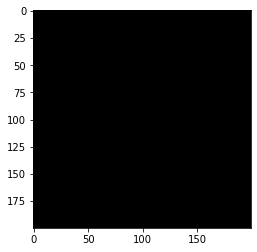

In [270]:
from rasterio.plot import show
ca = adjust_sigmoid(ortho, cutoff=0.6, gain=7, inv=False)
show(seg_ortho[:3,100:300,100:300])

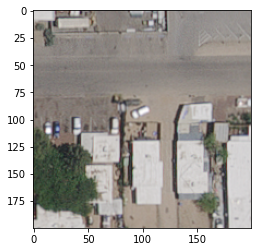

In [257]:
show(ortho[:3,100:300,100:300])

In [75]:
#odf = gpd.GeoDataFrame(geometry=boxes,crs="epsg:2868")
#odf.to_file("../../temp/subboxes.gpkg", driver="GPKG")

In [12]:
t1 = datetime.now()
segments_fz = felzenszwalb(np.moveaxis(ortho, 0, -1)[:,:,0], scale=25, sigma=0.5, min_size=20, multichannel=False)
t2 = datetime.now()
print(t2-t1)

0:00:01.379249


In [4]:
def segmentImage(loc_NAIPFile, seg_img_dir, overwrite=False):
    print("\tStarting segmentation of NAIP File: %s" % loc_NAIPFile)

    ofile_name = os.path.basename(loc_NAIPFile)[:-4] + "_Segmented.tif"

    o_file = os.path.join(seg_img_dir, ofile_name)

    if not os.path.exists(o_file) or overwrite:
        seg_start = datetime.now()
        #time.sleep(1)
        start = datetime.now()
        print("Segmented file doesn't exist or overwrite set. Creating at %s" % o_file)

        with rio.open(loc_NAIPFile) as inras:
            prof = inras.profile

            #initialize = rio.open(o_file, 'w', **prof).close()  # prevent parallel process from working on same file

            ras_array = inras.read()

            ras_array = np.moveaxis(ras_array, 0, -1)  # scikit-image wants array in (height, width, bands). Rasterio returns (bands, height, width)
            bands_array_seg = segmentArray(ras_array)
        
        #print("DTYPE: ", bands_array_seg.dtype)
        
        #print("SHAPE: ", bands_array_seg.shape)

        #return bands_array_seg.astype(np.int32)
    
        prof.update(
            count=1,
            dtype=np.int32
        )

        with rio.open(o_file, 'w', **prof) as oras:
            oras.write_band(1, bands_array_seg.astype(np.int32))

        seg_end = datetime.now()
        print("\tSegmentation took {}".format(seg_end-seg_start))

    with rio.open(o_file) as ras:
        seg_array = ras.read(1).astype(np.int32)


    return seg_array


def segmentArray(image_array, seg_type="felzenswalb"):
    print("Beginning image segmentation on array")
    seg_start = datetime.now()
    if seg_type == "felzenswalb":
        segments_fz = felzenszwalb(image_array, scale=25, sigma=0.5, min_size=3, multichannel=True)
    else:
        print("Unknown segmentation algorithm. Exiting...")
        raise ValueError

    seg_end = datetime.now()
    print(
        "Felzenszwalb number of segments: {}. \n\t{} elapsed.".format(len(np.unique(segments_fz)), seg_end - seg_start))

    return segments_fz


def calcSegmentMean(labeled_array, regs, in_band):
    mean_start = datetime.now()
    # label_im = label(segments, connectivity=1) + 1
    #regions = measure.regionprops(labeled_array.astype(np.int64), intensity_image=in_band)

    def loopRegions(region, in_array):
        #for r in regions:
        segment = region.label
        bbox = region.bbox
        min_row, max_row, min_col, max_col = bbox


        sub_array = in_array[min_row:min_col, max_row:max_col]
        #print(sub_array)

        sub_array[sub_array == segment] = r.mean_intensity
        #print(sub_array)

        in_array[min_row:min_col, max_row:max_col] = sub_array

        return in_array
    
    print("\tBeginning mean calculation on segments...")
    mean_array = np.copy(labeled_array)
    #mean_array = Parallel(n_jobs=4)(delayed(loopRegions)(r, mean_array) for r in regs)

    for r in regs:
        segment = r.label
        bbox = r.bbox
        min_row, max_row, min_col, max_col = bbox

        sub_array = mean_array[min_row:min_col, max_row:max_col]
        # print(sub_array)

        sub_array[sub_array == segment] = r.mean_intensity
        # print(sub_array)

        mean_array[min_row:min_col, max_row:max_col] = sub_array
    
    print("\t...Mean calculation complete.\n\t{} elapsed.".format(datetime.now() - mean_start))

    return mean_array



def vegIndexCalc(naip_array_list, indicies):
    print("Beginning VegIndexCalcs")
    bandRed = naip_array_list[0].astype(float)
    bandGreen = naip_array_list[1].astype(float)
    bandBlue = naip_array_list[2].astype(float)
    bandNIR = naip_array_list[3].astype(float)

    # IMPORTANT: Because of the soil line value in the SAVI indicies,
    #  all band value must be normalized between 0 and 1.
    bandRed /= 255.0
    bandNIR /= 255.0
    bandBlue /= 255.0

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    vi_calcs = {}
    for veg_index in indicies:

        if veg_index == "NDVI":
            vi = (bandNIR - bandRed) / (bandNIR + bandRed)

        elif veg_index == "SAVI":
            l = 0.5
            vi = ((bandNIR - bandRed) / (bandNIR + bandRed + l)) * (1 + l)

        elif veg_index == "MSAVI2":
            vi = ((2 * bandNIR + 1) - np.sqrt(np.square(2 * bandNIR + 1) - (8 * (bandNIR - bandRed)))) / 2

        elif veg_index == "EVI2":
            g = 2.5  # gain factor
            l = 1.0  # soil adjustment factor
            c_one = 6.0  # coefficient
            c_two = 7.5  # coefficient
            #vi = 2.5 * ((bandNIR - bandRed) / (bandNIR + (2.4 * bandRed) + 1))
            vi = g * ((bandNIR - bandRed) / ((bandNIR + c_one) * (bandRed - c_two) * (bandBlue + l)))

        elif veg_index == "OSAVI":
            vi = (bandNIR - bandRed) / (bandNIR + bandRed + 0.16)

        vi_calcs[veg_index] = vi * 1000  # multiply by 1000 so we can convert to int16 later without loosing precision

        del vi

    return vi_calcs


def getSubSetLandsat(naip_path, landsat_file, opath, overwrite=False):
    ssl_start = datetime.now()
    ofile = "Landsat8_" + os.path.basename(naip_path)

    landsat_opath = os.path.join(opath, ofile)

    if not os.path.exists(landsat_opath) or overwrite:
        start = datetime.now()
        reference_f = gdal.Open(naip_path)
        geo_transform = reference_f.GetGeoTransform()
        resx = geo_transform[1]
        resy = geo_transform[5]
        proj = reference_f.GetProjectionRef()
        minx = geo_transform[0]
        maxy = geo_transform[3]
        maxx = minx + (resx * reference_f.RasterXSize)
        miny = maxy + (resy * reference_f.RasterYSize)

        # build landsat tile from naip extent

        if "ndsi" in opath.lower() or "ndwi" in opath.lower():
            resampletype = "bilinear"
        else:
            resampletype = "bilinear"
            # resampletype = "near"

        gdal_warp = "gdalwarp -overwrite -tap -r %s -t_srs %s -tr %s %s -te_srs %s -te %s %s %s %s %s %s" % (
            resampletype, proj, resx, resy, proj, str(minx), str(miny), str(maxx), str(maxy), landsat_file,
            landsat_opath)
        logger.info("Executing gdal_warp operation on %s for footprint of naip file %s" % (landsat_file, naip_path))
        os.system(gdal_warp)

        logger.info("\tFinished qquad for %s landsat in %s" % (landsat_file, str(datetime.now() - ssl_start)))

    with rio.open(landsat_opath) as lras:
        lras_array = lras.read()

    if "ndsi" in opath.lower() or "ndwi" in opath.lower():
        lras_array = lras_array * 1000

    return lras_array.astype(np.int16)


def compoundArrays(array_stack, tiff_tags, arrays_dict):
    for name, array in arrays_dict.items():
        tiff_tags[len(tiff_tags) + 1] = name

        array_stack.append(array.astype(np.int16))

    return array_stack, tiff_tags

In [ ]:
"""
start = datetime.now()

seg_mean_band_arrays = []

with rio.open(in_naip) as ras:
    prof = ras.profile
    n_bands = prof["count"]
    for b in range(1, n_bands+1):
        print(b)
        if b == 1:
            ras.update_tags(b,NAME = "RED")
        
        band_array = ras.read(b)
       
        band_array_seg = segmentImage(band_array)

        # Write out segmented image
        #prof.update(
        #    dtype=rio.uint32,
        #    count=1
        #)
        #out_seg = in_naip[:-4] + "_fzseg.tif
        #with rio.open(r"Q:/AARMP_TestBed/NAIP/m_3211042_nw_12_1_20150530_band1_fz_segs.tif", 'w', **prof) as outras:
        #    outras.write_band(1, band_array_seg.astype(rio.uint32))

        output_band_array = calcSegmentMean(in_band=band_array, segments=band_array_seg)

        seg_mean_band_arrays.append(output_band_array)

#print(seg_mean_band_arrays)
veg_arrays_dict = vegIndexCalc(seg_mean_band_arrays, veg_indicies)

for vi_name in veg_indicies:
    seg_mean_band_arrays.append(veg_arrays_dict[vi_name])
"""

In [89]:
def generateStack(loc_NAIPFile): #, training_stack_dir, naip_band_order, veg_indicies):
    print("Starting on NAIP File: %s" % loc_NAIPFile)
    ofile_name = os.path.basename(loc_NAIPFile)[:-4] + "_TrainingStack.tif"

    o_file = os.path.join(training_stack_dir, ofile_name)

    if not os.path.exists(o_file):
        start = datetime.now()
        print("Training stack doesn't exist. Creating at %s" % o_file)

        with rio.open(loc_NAIPFile) as ras:
            prof = ras.profile

            initialize = rio.open(o_file, 'w', **prof).close()  # prevent parallel process for working on same file

            n_bands = prof["count"]

            output_array_stack = []

            tags = dict(naip_band_order)
            ras_array = ras.read()
            ras_array = np.moveaxis(ras_array, 0,
                                    -1)  # scikit-image wants array in (height, width, bands). Rasterio returns (bands, height, width)
            bands_array_seg = segmentImage(ras_array)

            # Identify segments as individual labels
            label_im = label(bands_array_seg, connectivity=1).astype(np.float32) + 1

            del bands_array_seg

            # Iterate through R,G,B,NIR bands and use the segmented image to calculate mean in zones/labels
            for b in range(1, n_bands + 1):
                print(b)

                band_array = ras.read(b)

                seg_mean_band = calcSegmentMean(in_band=band_array, labeled_array=label_im, characteristic="mean")

                output_array_stack.append(seg_mean_band.astype(np.int16))

            # CREATED BANDS FOR SEGMENT SIZE CHARACERISTICS (Area/Perimeter of segment, and % area of bounding box)
            geometric_arrays = calcSegmentMean(in_band=band_array, labeled_array=label_im, characteristic="geometry")
            del label_im

            output_array_stack, tags = compoundArrays(output_array_stack, tags, geometric_arrays)

            # CREATE VEG INDEX ARRAYS
            veg_arrays_dict = vegIndexCalc(output_array_stack, veg_indicies)
            output_array_stack, tags = compoundArrays(output_array_stack, tags, veg_arrays_dict)

            # CREATE LANDSAT INDEX ARRAYS AND APPEND TO MAIN ARRAY WITH TAGS
            # GET ALL LANDSAT BAND ARRAYS AND APPEND TO MAIN ARRAY
            landsat_qquad_array = getSubSetLandsat(loc_NAIPFile, landsat_file, landsat_qquad_dir, overwrite=False)
            for i in range(len(landsat_qquad_array)):
                output_array_stack.append(landsat_qquad_array[i].astype(np.int16))
                tags[len(tags) + 1] = "L8_" + str(i + 1)

            # APPEND NDSI ARRAY TO MAIN ARRAY
            landsat_ndsi_array = getSubSetLandsat(loc_NAIPFile, ndsi_file, ndsi_qquad_dir, overwrite=False)
            output_array_stack.append(landsat_ndsi_array[
                                          0])  # full read has shape (1, 7500, 6900). Must be 7500,6900 for equal shape of other arrays
            tags[len(tags) + 1] = "L8_NDSI"

            # APPEND NDWI ARRAY TO MAIN ARRAY
            landsat_ndwi_array = getSubSetLandsat(loc_NAIPFile, ndwi_file, ndwi_qquad_dir, overwrite=False)
            output_array_stack.append(landsat_ndwi_array[0])
            tags[len(tags) + 1] = "L8_NDWI"

            # naip_end = datetime.now()

            out_array_stack_np = np.stack(output_array_stack, axis=0)
            # print(out_array_stack_np.shape)
            # print(out_array_stack_np.dtype)

        prof.update(
            dtype=rio.int16,
            count=len(out_array_stack_np)
        )

        with rio.open(o_file, 'w', **prof) as outras:
            for n, tag in tags.items():
                outras.update_tags(n, NAME=tag)
            outras.write(out_array_stack_np.astype(rio.int16))

        print("FINISHED")

        end = datetime.now()
        print("\tElapsed %s" % (str(end - start)))

In [90]:
logger.basicConfig(level=logger.INFO)

veg_indicies = ["NDVI", "SAVI", "OSAVI", "MSAVI2", "EVI2"]

naip_band_order = {1: "RED", 2: "GREEN", 3: "BLUE", 4: "NIR"}

base_datadir = os.path.abspath(r"M:\Data")
base_landsatdir = os.path.join(base_datadir, "Landsat8")
ndsi_qquad_dir = os.path.join(base_datadir, "NDSI")
ndwi_qquad_dir = os.path.join(base_datadir, "NDWI")
landsat_qquad_dir = os.path.join(base_landsatdir, "byNAIPDOY_QQuads")

landsat_file = os.path.os.path.join(base_landsatdir, "Landsat1to8_TOA_NAIPAcquiDate_merge_rectified.tif")
# LOCATION OF THE NDSI FILE
ndsi_file = os.path.join(ndsi_qquad_dir, "LandsatOLI_NDSI_30m.tif")
# LOCATION OF THE NDWI FILE
ndwi_file = os.path.join(ndwi_qquad_dir, "LandsatOLI_NDWI_30m.tif")

In [4]:

training_stack_dir = os.path.join(base_datadir, "TrainingImageStack")
if not os.path.exists(training_stack_dir):
    os.mkdir(training_stack_dir)

# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

print("Reading in class_points_file...")
loc_class_points = os.path.abspath(
    r"Q:\GoogleDrive\AridRiparianProject\WorkingDirectory\classificationPoints_join.shp")
training_data_df = gpd.read_file(loc_class_points, crs={'init': 'epsg:26912'})

Reading in class_points_file...


________________________________


In [91]:
segmentedImagesDir = r"Q:\Arid Riparian Project\Data\test"
bands_array_seg = segmentImage(r"Q:\Arid Riparian Project\Data\NAIP_2015_Compressed\m_3211337_se_12_1_20150725.tif",
                               segmentedImagesDir, overwrite=True)

	Starting segmentation of NAIP File: Q:\Arid Riparian Project\Data\NAIP_2015_Compressed\m_3211337_se_12_1_20150725.tif
Segmented file doesn't exist or overwrite set. Creating at Q:\Arid Riparian Project\Data\test\m_3211337_se_12_1_20150725_Segmented.tif
Beginning image segmentation on array


C:\Program Files\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:60: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of segments: 3052247. 
	0:03:10.446018 elapsed.
	Segmentation took 0:03:17.888469


In [92]:
label_im = label(bands_array_seg, connectivity=1).astype(np.float64) + 1

In [93]:
label_im.shape

(7690, 6670)

In [102]:
loc_NAIPFile = r"Q:\Arid Riparian Project\Data\NAIP_2015_Compressed\m_3211337_se_12_1_20150725.tif"

with rio.open(loc_NAIPFile) as ras:
    band_array = ras.read(1)
    
    regions = measure.regionprops(label_im.astype(np.int32), intensity_image=band_array)
    seg_mean_band1 = calcSegmentMean(in_band=band_array, regs=regions, labeled_array=label_im)


	Beginning mean calculation on segments...
	...Mean calculation complete.
	0:03:09.990053 elapsed.


In [97]:
values_map = {}
for i,r in enumerate(regions):
    values_map[r.label] = r.mean_intensity

In [30]:
rows, cols = label_im.shape
flat_pixels = label_im.reshape(rows*cols)

In [96]:
def vec_translate(a, my_dict):    
    return np.vectorize(my_dict.__getitem__)(a)

In [98]:
mean_array = vec_translate(label_im, values_map)

In [103]:
arr_diff = mean_array - seg_mean_band1

In [108]:
l = [5,8,7,6,2,16,84,13]
g = np.array(l)
del l
print(g)

[ 5  8  7  6  2 16 84 13]


In [61]:
start = datetime.now()
mean_array = np.copy(label_im)
for x in np.nditer(label_im, op_flags = ['readwrite']):
    x = values_map[int(x)].mean_intensity
    #if x - int(x) != 0:
    #    raise Exception
    #print(values_map[int(x)].mean_intensity)
    mean_array[label_im == x] = values_map[int(x)].mean_intensity
end = datetime.now()
print(end-start)

KeyboardInterrupt: 

______________________________________

In [ ]:
with rio.open(loc_NAIPFile) as ras:
    band_array = ras.read(2)
    
    seg_mean_band2 = calcSegmentMean(in_band=band_array, labeled_array=label_im, characteristic="mean")
seg_mean_band2

In [ ]:
with rio.open(loc_NAIPFile) as ras:
    band_array = ras.read(3)
    
    seg_mean_band3 = calcSegmentMean(in_band=band_array, labeled_array=label_im, characteristic="mean")

In [ ]:
with rio.open(loc_NAIPFile) as ras:
    band_array = ras.read(4)
    
    seg_mean_band4 = calcSegmentMean(in_band=band_array, labeled_array=label_im, characteristic="mean")

In [60]:

start = datetime.now()
with rio.open(r"Q:\Arid Riparian Project\Data\NAIP_2015_Compressed\m_3211337_se_12_1_20150725.tif") as ras:
    prof = ras.profile
    #initialize = rio.open(o_file, 'w', **prof).close() # prevent parallel process for working on same file
    n_bands = ras.count

    output_array_stack = []

    tags = dict(naip_band_order)
    #ras_array = ras.read()
    #ras_array = np.moveaxis(ras_array, 0, -1)  # scikit-image wants array in (height, width, bands). Rasterio returns (bands, height, width)
    
     # Identify segments as individual labels
    label_im = label(bands_array_seg, connectivity=1).astype(np.float32) + 1

    # Iterate through R,G,B,NIR bands and use the segmented image to calculate mean in zones/labels
    for b in range(1, n_bands + 1):
        print(b)

        band_array = ras.read(b)

        #bands_array_seg = segmentImage(band_array)
        regions = measure.regionprops(label_im.astype(np.int32), intensity_image=band_array)

        # Identify segments as individual labels
        #label_im = label(bands_array_seg, connectivity=1).astype(np.float32) + 1

        seg_mean_band = calcSegmentMean(in_band=band_array, regs=regions, labeled_array=label_im)

        output_array_stack.append(seg_mean_band.astype(np.int16))

out_array_stack_np = np.stack(output_array_stack, axis=0)
            # print(out_array_stack_np.shape)
            # print(out_array_stack_np.dtype)

prof.update(
    dtype=rio.int16,
    count=len(out_array_stack_np)
) 

with rio.open(r"Q:\Arid Riparian Project\Data\test\seg_test_m_3211337_se_12_1_20150725_4band_mean.tif", 'w', **prof) as outras:
    #for n, tag in tags.items():
    #    outras.update_tags(n, NAME=tag)
    outras.write(out_array_stack_np.astype(rio.int16))
end = datetime.now()

print(end-start)

	Starting segmentation of NAIP File: Q:\Arid Riparian Project\Data\NAIP_2015_Compressed\m_3211337_se_12_1_20150725.tif
Segmented file doesn't exist or overwrite set. Creating at Q:\Arid Riparian Project\Data\test\m_3211337_se_12_1_20150725_Segmented.tif
Beginning image segmentation on array


C:\Program Files\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:60: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of segments: 3052247. 
	0:02:48.317097 elapsed.
	Segmentation took 0:02:54.461148
1
	Beginning mean calculation on segments...


NameError: name 'r' is not defined

In [32]:
with rio.open(r"Q:\Arid Riparian Project\Data\test\seg_test_m_3211337_se_12_1_20150725_4band_mean.tif", 'w', **prof) as outras:
    #for n, tag in tags.items():
    #    outras.update_tags(n, NAME=tag)
    outras.write(out_array_stack_np.astype(rio.int16))

print(end-start)

-1 day, 23:26:16.842730


In [28]:
for n, tag in tags.items():
    print(n,tag)

1 RED
2 GREEN
3 BLUE
4 NIR


In [ ]:
count = 0
naip_files = []
for loc_NAIPFile, group in training_data_df.groupby("NAIP_FILE"):
    # print(loc_NAIPFile)
    count += 1
    # loc_NAIPFile.replace("\\", "/")  # normalize for windows paths
    # print(count, " - ", os.path.basename(loc_NAIPFile))
    naip_files.append(loc_NAIPFile)

    print("Starting on NAIP File: %s" % loc_NAIPFile)
    ofile_name = os.path.basename(loc_NAIPFile)[:-4] + "_TrainingStack.tif"

    o_file = os.path.join(training_stack_dir, ofile_name)

    if not os.path.exists(o_file):
        start = datetime.now()
        print("Training stack doesn't exist. Creating at %s" % o_file)

        with rio.open(loc_NAIPFile) as ras:
            prof = ras.profile
            initialize = rio.open(o_file, 'w', **prof).close() # prevent parallel process for working on same file
            n_bands = prof["count"]

            output_array_stack = []

            tags = dict(naip_band_order)
            ras_array = ras.read()
            ras_array = np.moveaxis(ras_array, 0,
                                    -1)  # scikit-image wants array in (height, width, bands). Rasterio returns (bands, height, width)
            bands_array_seg = segmentImage(ras_array)

            # Identify segments as individual labels
            label_im = label(bands_array_seg, connectivity=1).astype(np.float32) + 1

            # Iterate through R,G,B,NIR bands and use the segmented image to calculate mean in zones/labels
            for b in range(1, n_bands + 1):
                print(b)

                band_array = ras.read(b)

                seg_mean_band = calcSegmentMean(in_band=band_array, labeled_array=label_im, characteristic="mean")

                output_array_stack.append(seg_mean_band.astype(np.int16))

            # CREATED BANDS FOR SEGMENT SIZE CHARACERISTICS (Area/Perimeter of segment, and % area of bounding box)
            #geometric_arrays = calcSegmentMean(in_band=band_array, labeled_array=label_im, characteristic="geometry")

            # CREATE VEG INDEX ARRAYS
            #veg_arrays_dict = vegIndexCalc(output_array_stack, veg_indicies)

            #output_array_stack, tags = compoundArrays(output_array_stack, tags, geometric_arrays)
            #output_array_stack, tags = compoundArrays(output_array_stack, tags, veg_arrays_dict)


            # CREATE LANDSAT INDEX ARRAYS AND APPEND TO MAIN ARRAY WITH TAGS
            # GET ALL LANDSAT BAND ARRAYS AND APPEND TO MAIN ARRAY
            landsat_qquad_array = getSubSetLandsat(loc_NAIPFile, landsat_file, landsat_qquad_dir, overwrite=False)
            for i in range(len(landsat_qquad_array)):
                output_array_stack.append(landsat_qquad_array[i].astype(np.int16))
                tags[len(tags) + 1] = "L8_" + str(i + 1)

            # APPEND NDSI ARRAY TO MAIN ARRAY
            landsat_ndsi_array = getSubSetLandsat(loc_NAIPFile, ndsi_file, ndsi_qquad_dir, overwrite=False)
            output_array_stack.append(landsat_ndsi_array[0])  # full read has shape (1, 7500, 6900). Must be 7500,6900 for equal shape of other arrays
            tags[len(tags) + 1] = "L8_NDSI"

            # APPEND NDWI ARRAY TO MAIN ARRAY
            landsat_ndwi_array = getSubSetLandsat(loc_NAIPFile, ndwi_file, ndwi_qquad_dir, overwrite=False)
            output_array_stack.append(landsat_ndwi_array[0])
            tags[len(tags) + 1] = "L8_NDWI"

            # naip_end = datetime.now()

            out_array_stack_np = np.stack(output_array_stack, axis=0)
            # print(out_array_stack_np.shape)
            # print(out_array_stack_np.dtype)

        prof.update(
            dtype=rio.int16,
            count=len(out_array_stack_np)
        ) 

        with rio.open(o_file, 'w', **prof) as outras:
            for n, tag in tags.items():
                outras.update_tags(n, NAME=tag)
            outras.write(out_array_stack_np.astype(rio.int16))

        print("FINISHED")

        end = datetime.now()
        print("\tElapsed %s" % (str(end - start)))
        
    raise ValueError


In [ ]:
out_array_stack_np.shape

In [ ]:
#with rio.open(o_file+"_1")
prof.update(count=4)

In [ ]:
prof.update(count=1)
ofile = o_file[:-4] + "_1.tif"
initialize = rio.open(ofile, 'w', **prof).close()

In [ ]:
prof.update(count=14)
with rio.open(ofile, 'w', **prof) as outras:
    for n, tag in tags.items():
        outras.update_tags(n, NAME=tag)
    outras.write(out_array_stack_np.astype(rio.int16))

In [ ]:
print(bands_array_seg.shape)
print(label_im.shape)

In [6]:
with rio.open(r"M:\Data\SegmentedNAIPImages\m_3110930_nw_12_1_20150621_Segmented.tif") as ras:
    prof = ras.profile
    bands_array_seg = ras.read(1)
    print(bands_array_seg.shape)

(7650, 6660)


In [7]:
#bands_array_seg = np.moveaxis(bands_array_seg, 0, -1)
print(bands_array_seg.shape)

(7650, 6660)


In [29]:
label_im = label(bands_array_seg, connectivity=1).astype(np.float32) + 1

#empty_ar = np.zeros(bands_array_seg.shape).astype(np.byte)

In [18]:
label_im

array([[  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          2.11700000e+03,   2.11700000e+03,   2.11700000e+03],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          2.11700000e+03,   2.11700000e+03,   2.11700000e+03],
       [  1.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          2.11700000e+03,   2.11700000e+03,   2.11700000e+03],
       ..., 
       [  3.98373700e+06,   3.98373700e+06,   3.98373700e+06, ...,
          3.98508700e+06,   3.98508700e+06,   3.98508700e+06],
       [  3.98373700e+06,   3.98373700e+06,   3.98373700e+06, ...,
          3.98508700e+06,   3.98508700e+06,   3.98508700e+06],
       [  3.98373700e+06,   3.98373700e+06,   3.98074900e+06, ...,
          3.98508700e+06,   3.98508700e+06,   3.98508700e+06]], dtype=float32)

In [10]:
regions = measure.regionprops(label_im.astype(np.int32))#, intensity_image=empty_ar)
print("got regions")

got regions


In [11]:
print(label_im.shape)


(7650, 6660)


In [30]:
area_array = np.copy(label_im)

for r in regions:
    segment = r.label
    bbox = r.bbox
    min_row, max_row, min_col, max_col = bbox
    sub_array = np.copy(label_im[min_row:min_col, max_row:max_col]) # BEN
    #print("SUB ARRAY SHAPE: ", sub_array.shape)
    area = r.area
    #print(area)


    sub_array[sub_array == segment] = area
    #print(sub_array.astype(np.int))

    area_array[min_row:min_col, max_row:max_col] = sub_array
    

#area_array = np.moveaxis(area_array, 0, -1)
with rio.open(r"M:\Data\SegmentedNAIPImages\Area1.tif", 'w', **prof) as ras:
    ras.write_band(1, area_array.astype(np.int32))


C:\Program Files\Anaconda3\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [27]:
label_im

array([[  60.,   60.,   60., ...,  138.,  138.,  138.],
       [  60.,   60.,   60., ...,  138.,  138.,  138.],
       [  60.,   60.,   18., ...,  138.,  138.,  138.],
       ..., 
       [  20.,   20.,   20., ...,   28.,   28.,   28.],
       [  20.,   20.,   20., ...,   28.,   28.,   28.],
       [  20.,   20.,   91., ...,   28.,   28.,   28.]], dtype=float32)

In [33]:
label_im = label(bands_array_seg, connectivity=1).astype(np.float32) + 1

#empty_ar = np.zeros(bands_array_seg.shape).astype(np.byte)

def calculateGeometry1(seg_array, regs, attrib):
    
    labeled_array = label(seg_array, connectivity=1).astype(np.float32) + 1
    
    out_array = np.copy(labeled_array)

    for r in regs:
        segment = r.label
        bbox = r.bbox
        min_row, max_row, min_col, max_col = bbox
        sub_array = labeled_array[min_row:min_col, max_row:max_col]
        
        if attrib.lower() == "area":
            value = r.area
        elif attrib.lower() == "perim":
            value = r.perimeter
        elif attrib.lower() == "perc_area":
            value = r.extent * 100
            
        sub_array[sub_array == segment] = value
        
        out_array[min_row:min_col, max_row:max_col] = sub_array
    
    return out_array
        
def calculateGeometry(labeled_array, regs):
    start = datetime.now()
    # regions = measure.regionprops(labeled_array.astype(np.int32))  #, intensity_image=empty_ar)
    # print("got regions")

    area_array = np.copy(labeled_array)
    perim_array = np.copy(labeled_array)
    ratio_area_array = np.copy(labeled_array)  # ratio area of pixels in bounding box

    array_dict = {"area": area_array,
                  "perim": perim_array,
                  "perc_area": ratio_area_array}

    for r in regs:
        segment = r.label
        bbox = r.bbox
        min_row, max_row, min_col, max_col = bbox
        sub_array = np.copy(labeled_array[min_row:min_col, max_row:max_col])  # BEN
        #print("SUB ARRAY SHAPE: ", sub_array.shape)

        values = {"area": r.area,
                  "perim": r.perimeter,
                  "perc_area": (r.extent * 100)}
        
        for characteristic, array in array_dict.items():
            ch_sub_array = np.copy(sub_array)

            ch_sub_array[ch_sub_array == segment] = values[characteristic]

            array[min_row:min_col, max_row:max_col] = ch_sub_array
            #print("label img:",labeled_array)
            #print(characteristic, array)
            
            #sub_array[sub_array == segment] = area
            #print(sub_array.astype(np.int))

            #area_array[min_row:min_col, max_row:max_col] = sub_array
        #raise ValueError

    end = datetime.now()
    #print("Elapsed: ", end - start)
    return array_dict

In [22]:
ars = calculateGeometry(label_im, regions)

In [19]:
label_im

array([[  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          2.11700000e+03,   2.11700000e+03,   2.11700000e+03],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          2.11700000e+03,   2.11700000e+03,   2.11700000e+03],
       [  1.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          2.11700000e+03,   2.11700000e+03,   2.11700000e+03],
       ..., 
       [  3.98373700e+06,   3.98373700e+06,   3.98373700e+06, ...,
          3.98508700e+06,   3.98508700e+06,   3.98508700e+06],
       [  3.98373700e+06,   3.98373700e+06,   3.98373700e+06, ...,
          3.98508700e+06,   3.98508700e+06,   3.98508700e+06],
       [  3.98373700e+06,   3.98373700e+06,   3.98074900e+06, ...,
          3.98508700e+06,   3.98508700e+06,   3.98508700e+06]], dtype=float32)

In [34]:
for att in ["area", "perim", "perc_area"]:
    print("Starting %s" % att)
    oa = calculateGeometry1(bands_array_seg, regions, att)


    o_file = os.path.join("M:\Data\TrainingImageStack", att + "2.tif")
    with rio.open(o_file, 'w', **prof) as ras:
        ras.write_band(1, oa.astype(np.int32))

Starting area


C:\Program Files\Anaconda3\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Starting perim
Starting perc_area


In [62]:
label_im

array([[  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          2.11700000e+03,   2.11700000e+03,   2.11700000e+03],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          2.11700000e+03,   2.11700000e+03,   2.11700000e+03],
       [  1.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          2.11700000e+03,   2.11700000e+03,   2.11700000e+03],
       ..., 
       [  3.98373700e+06,   3.98373700e+06,   3.98373700e+06, ...,
          3.98508700e+06,   3.98508700e+06,   3.98508700e+06],
       [  3.98373700e+06,   3.98373700e+06,   3.98373700e+06, ...,
          3.98508700e+06,   3.98508700e+06,   3.98508700e+06],
       [  3.98373700e+06,   3.98373700e+06,   3.98074900e+06, ...,
          3.98508700e+06,   3.98508700e+06,   3.98508700e+06]], dtype=float32)

In [50]:
for k,v in ars.items():
    print(k,v.shape)
    o_file = os.path.join("M:\Data\TrainingImageStack",k + ".tif")
    with rio.open(o_file, 'w', **prof) as ras:
        ras.write_band(1, v.astype(np.int32))

area (7650, 6660)


C:\Program Files\Anaconda3\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


perc_area (7650, 6660)
perim (7650, 6660)


In [15]:

#area_array = np.moveaxis(area_array, 0, -1)
with rio.open(r"M:\Data\SegmentedNAIPImages\Area1.tif", 'w', **prof) as ras:
    ras.write_band(1, ar.astype(np.int32))


C:\Program Files\Anaconda3\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [32]:
gdal.Open(r"M:\Data\ValleyBottoms\Watersheds\1407\HRNHDPlusRasters1407\fac.tif")